# Blood Pressure

In [1]:
import json
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import arviz as az
import pymc3 as pm
import xarray as xr

import matplotlib.pyplot as plt
from plotnine import *

%load_ext dotenv
%dotenv
PROJECT_DIR=Path(os.environ.get('PROJECT_DIR'))
sys.path.append(str(PROJECT_DIR))

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

theme_set(theme_bw())
pd.set_option('display.max_columns', 100)
# working with arviz structure?
SEED = 1925

DATA_FILEPATH = PROJECT_DIR / 'data'  / 'blood-pressure' 
DATA_FILEPATH

PosixPath('/media/david/T7/code/bmcp/bmcp-notes/data/blood-pressure')

# Background
+ Collected every morning and night 6 April - 12 April 2023
+ Automated machine < $50
+ Machine detects incorrect strap tightness and errors out
+ Cannot find repeatability/accuracy data on machine, but [this](https://www.health.harvard.edu/blog/home-blood-pressure-monitors-arent-accurate-201410297494)
+ table below from [How Accurate Are Home Blood Pressure Devices in Use? A Cross-Sectional Study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4889144/)

# Prior Selection

<img src="img/Ecosh_Blood_Pressure_Chart.jpg" alt="isolated" width="600"/>

# Model Specification

### Likelihood
+ We have to define a generative function, because this informs us what priors are required.
+ In this case, I arbitrarily assume that multiple readings of a 50 - 54 year old female's **blood pressure are normally distributed**.
+ I am not sure this is correct because the data seems to indicate a time of day effect, but we will use this as a model of the data, we are not claiming the data comes from a normal distribution.
+ The other argument in favour of normally distributed data would be if we assume a gauge r&r error in the measuring device that is normally distributed around the true reading. This would tend to add to inherent variations. Maybe?

### Priors

+ From table above - For female Age 55 -59
+ normal range systolic
    + min 118
    + max 144
    + normal 131 (midpoint of min/max)
+ normal range diastolic
    + min 82
    + max 90
    + normal 86 (midpoint of minmax)
+ Based on the assumption about normally distributed, we need to select distributions for 2 priors, mu and sigma
    + mu
        + In the general case, this has to model the distribution of the mean of all person's blood pressures
        + If we make the assumption that most people are healthy, then this could be centred at the midpoint of the healthy range. However, the mean could be as low or high as the lowest or highest blood pressure any living person could have. According to [ScienceABC - How high can blood pressure go?](https://www.scienceabc.com/eyeopeners/how-high-can-a-blood-pressure-go.html):
            + sys >180 and or dia > 100 requires immediate medical attention. Let's assume that anyone with sys at 181 or dia at 100
            + sys <90 and/or dia < 60 is considered low blood pressure [Mayo Clinic Low Blood Pressure](https://www.mayoclinic.org/diseases-conditions/low-blood-pressure/symptoms-causes/syc-20355465)
        + Therefore we could select a distribution for mu that ranges from 80 to 190, but is located at the midpoint of the healthy range - 131
        + We could start with uniform distributions:
            + sys: Uniform(80, 190)
            + dia: Uniform(50, 100)
        + Alternatively, in order to weight the distribution more at the midpoint of the healthy range we could use a normal distribution
            + sys: Normal(131, max((190-131/3), (131-90/3)) where the stdev of this is ensures that the min/max possible values are at most 3 standard deviations away from the mean
            + dia: Normal(86, max((100-86/3), (86-50/3))
    + sigma
        + this parameter defines the standard deviation of our normally distributed model of the data
        + According to (American Journal of Hypertension - Blood Pressure Variability: The Challenge of Variation)[https://academic.oup.com/ajh/article/21/1/3/137216] the standard deviation of a person with 131 systolic blood pressure across multiple clinic measurements is an incredibly high  13. For simplicity I will assume this does not vary with true value, but constant across the full range of possible readings.
        + If we assume that some clinics or machines have better repeatability than others then we should be able to selct a sigma lower that this value, but I don't think perfect measurement exists, so I will arbitrarily select a minimum of 1
        + We could go with a uniform distribution:
            + sys: Uniform(1, 14)
            + dia: Uniform(1, 14)
        + Alternatively, we could weight the distribution like this:
            + sys: Normal(7.5, 2.0) clipped at 0
            + dia: Normal(7.5, 2.0) clipped at 0  

# Data

In [3]:
day_num = np.array([[d]*2 for d in range(0,7)]).flatten()
systolic = [118, 171, 159, 156, 122, 155, 129, 152, 116, 148, 133, 145, 131, 124]
diastolic = [88, 77, 75, 73, 86, 74, 64, 73, 67, 69, 75, 76, 76, 62]
heart_rate = [68, 54, 58, 58, 63, 57, 62, 55, 57, 57, 57, 57, 67, 68]
tod = ['AM', 'PM']*7
tod
df = pd.DataFrame({'day': day_num, 'tod': tod, 'systolic': systolic, 'diastolic': diastolic, 'heart_rate': heart_rate})
df = pd.melt(df, id_vars=['day', 'tod']).rename(columns={'variable': 'measure'})
df['measure'] = df['measure'].astype('category')
df.head()

,day,tod,measure,value
0,0,AM,systolic,118
1,0,PM,systolic,171
2,1,AM,systolic,159
3,1,PM,systolic,156
4,2,AM,systolic,122


In [4]:
df.groupby('measure')['value'].describe()

,count,mean,std,min,25%,50%,75%,max
measure,,,,,,,,
diastolic,14.0,73.928571,7.226706,62.0,70.00,74.5,76.00,88.0
heart_rate,14.0,59.857143,4.833491,54.0,57.00,57.5,62.75,68.0
systolic,14.0,139.928571,17.380202,116.0,125.25,139.0,154.25,171.0


In [5]:
df.groupby(['tod', 'measure'])['value'].describe()

count        mean        std    min    25%    50%    75%  \
tod measure                                                                
AM  diastolic     7.0   75.857143   8.858679   64.0   71.0   75.0   81.0   
    heart_rate    7.0   61.714286   4.608481   57.0   57.5   62.0   65.0   
    systolic      7.0  129.714286  14.465065  116.0  120.0  129.0  132.0   
PM  diastolic     7.0   72.000000   5.099020   62.0   71.0   73.0   75.0   
    heart_rate    7.0   58.000000   4.618802   54.0   56.0   57.0   57.5   
    systolic      7.0  150.142857  14.205968  124.0  146.5  152.0  155.5   

                  max  
tod measure            
AM  diastolic    88.0  
    heart_rate   68.0  
    systolic    159.0  
PM  diastolic    77.0  
    heart_rate   68.0  
    systolic    171.0

In [6]:
df.head()

,day,tod,measure,value
0,0,AM,systolic,118
1,0,PM,systolic,171
2,1,AM,systolic,159
3,1,PM,systolic,156
4,2,AM,systolic,122


# Data Distributions

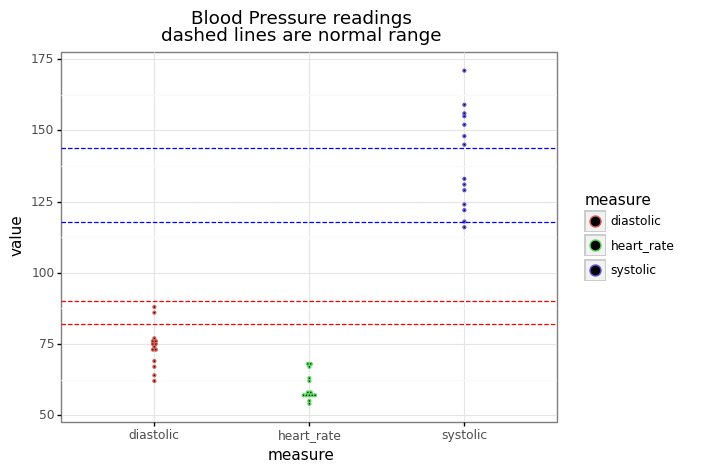

In [7]:
p = (ggplot(df, aes(x='measure', y='value', color='measure')) +
     geom_dotplot(binwidth=1, binaxis='y', stackdir='center', dotsize=1.0) +
     geom_hline(yintercept=144, color='blue', linetype='dashed') +
     geom_hline(yintercept=118, color='blue', linetype='dashed') +
     geom_hline(yintercept=82, color='red', linetype='dashed') +
     geom_hline(yintercept=90, color='red', linetype='dashed') +
     labs(title='Blood Pressure readings\ndashed lines are normal range')
    )
p.draw();

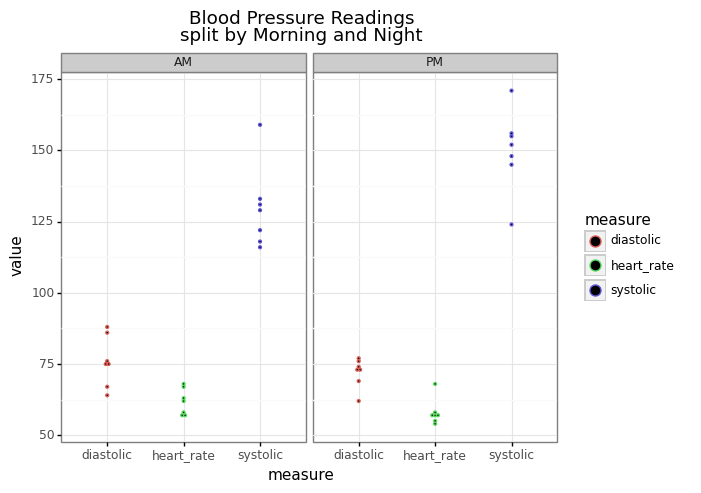

In [8]:
p = (ggplot(df, aes(x='measure', y='value', color='measure')) +
     geom_dotplot(binwidth=1, binaxis='y', stackdir='center', dotsize=1.0) +
     facet_wrap('tod') +
     labs(title='Blood Pressure Readings\nsplit by Morning and Night')
    )
p.draw();

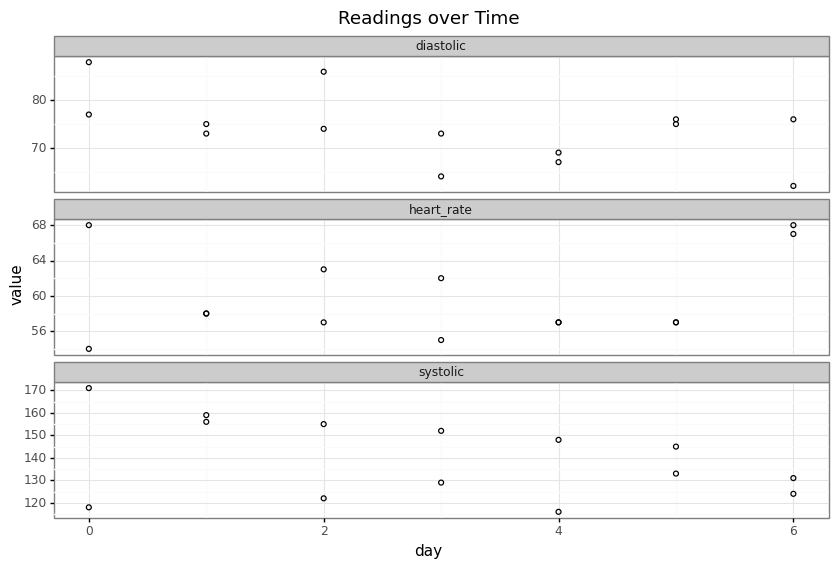

In [9]:
p = (ggplot(df, aes(x='day', y='value')) +
     geom_point(fill='none') + # dotplot(binwidth=1, binaxis='y', stackdir='center', dotsize=1.0) +
     facet_wrap('measure', nrow=3, scales='free_y') +
     labs(title='Readings over Time') +
     theme(figure_size=(10, 6))
    )
p.draw();

# Models

In [10]:
df.head()

,day,tod,measure,value
0,0,AM,systolic,118
1,0,PM,systolic,171
2,1,AM,systolic,159
3,1,PM,systolic,156
4,2,AM,systolic,122


## Systolic

+ Uniform priors
    + $bp \sim Normal(\mu, \sigma)$
        + $\mu \sim Uniform(80, 190)$
        + $\sigma \sim Uniform(1, 14)$
        
+ Normal priors
    + $bp \sim normal(\mu, \sigma)$
        + $\mu \sim Normal(131, max((190-131/3), (131-90/3))$
        + $\sigma \sim Normal(7.5, 2)$

### Uniform Priors

In [11]:
sys_df = df[df['measure']=='systolic']

with pm.Model() as sys_model_uni_prior:
    sys_mu = pm.Uniform('sys_mu', 80, 190)
    sys_sigma = pm.Uniform('sys_sigma', 1, 14)

    sys_bp = pm.Normal("sys_bp", mu=sys_mu, sigma=sys_sigma, observed = sys_df['value'].values)
    
    prior = pm.sample_prior_predictive()
    trace1 = pm.sample()
    # post = pm.sample_posterior_predictive(trace1)
    idata_sys_model_uni_prior = az.from_pymc3(trace=trace1, prior=prior)

/tmp/ipykernel_302646/3631677277.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sys_sigma, sys_mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


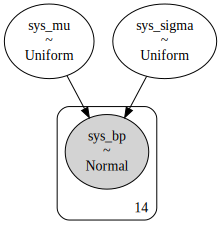

In [12]:
pm.model_to_graphviz(sys_model_uni_prior)

In [13]:
idata_sys_model_uni_prior

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

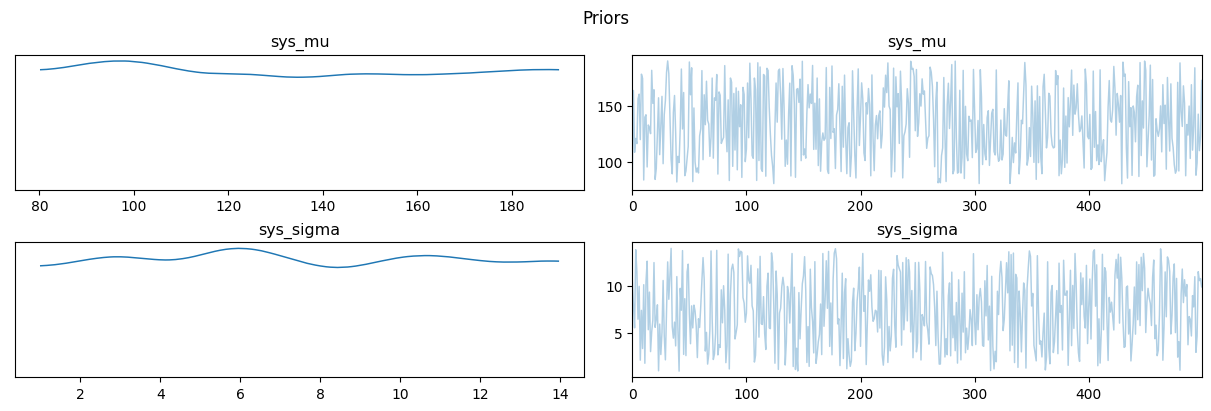

In [14]:
az.plot_trace(idata_sys_model_uni_prior.prior, var_names=['sys_mu', 'sys_sigma']);
plt.suptitle('Priors')
plt.show();

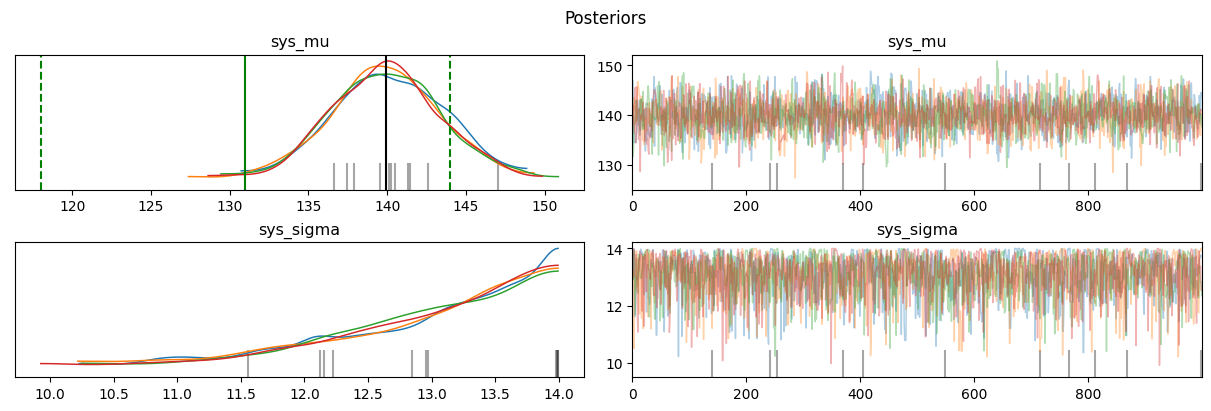

In [15]:
axes = az.plot_trace(idata_sys_model_uni_prior, compact=False);
axes[:, 0][0].axvline(118, color='green', linestyle='dashed')
axes[:, 0][0].axvline(144, color='green', linestyle='dashed')
axes[:, 0][0].axvline(131, color='green', linestyle='solid')
axes[:, 0][0].axvline(sys_df['value'].mean(), color='black')
plt.suptitle('Posteriors')
plt.show();
# Dashed green lines are normal range - solid green line is midpoint

In [16]:
sys_post_mu = idata_sys_model_uni_prior.posterior.sys_mu.to_dataframe().reset_index().drop(columns=['chain', 'draw'])
prob_high = ((sys_post_mu > 144).sum() / len(sys_post_mu)).values[0]
print(f'uniform model - probability mean systolic bp above normal: {prob_high}')

uniform model - probability mean systolic bp above normal: 0.1215


### Normal priors

+ Normal priors
    + $bp \sim normal(\mu, \sigma)$
        + $\mu \sim Normal(131, max((190-131/3), (131-90/3))$
        + $\sigma \sim Normal(7.5, 2)$

In [17]:
with pm.Model() as sys_model_norm_prior:
    sys_mu = pm.Normal('sys_mu', 131, max(190-(131/3), 131-(90/3)))
    sys_sigma = pm.Normal('sys_sigma', 7.5, 2)

    sys_bp = pm.Normal("sys_bp", mu=sys_mu, sigma=sys_sigma, observed = sys_df['value'].values)
    
    prior = pm.sample_prior_predictive()
    trace2 = pm.sample()
    # post = pm.sample_posterior_predictive(trace2)
    idata_sys_model_norm_prior = az.from_pymc3(trace=trace2, prior=prior)

/tmp/ipykernel_302646/148282647.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sys_sigma, sys_mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


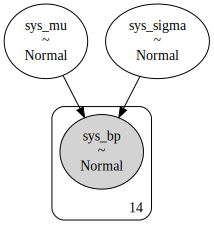

In [18]:
pm.model_to_graphviz(sys_model_norm_prior)

In [19]:
idata_sys_model_norm_prior

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

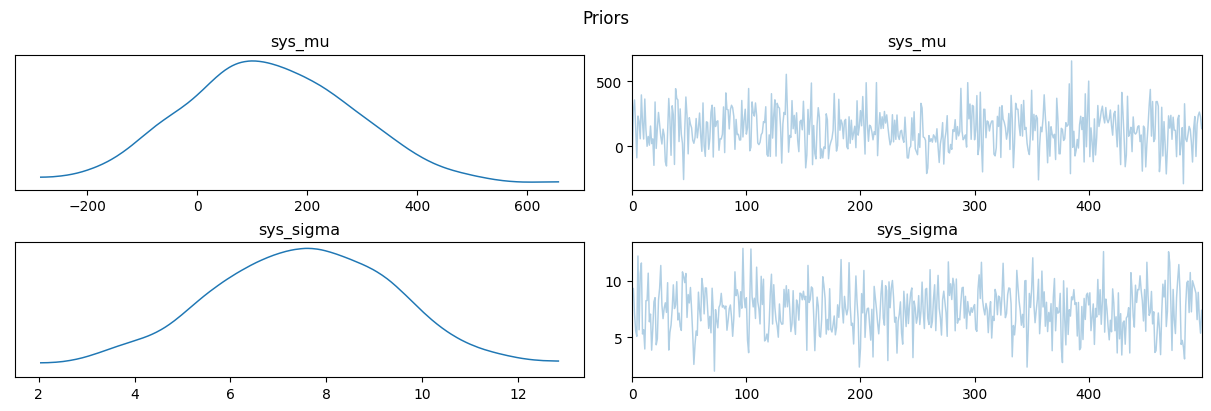

In [20]:
az.plot_trace(idata_sys_model_norm_prior.prior, var_names=['sys_mu', 'sys_sigma']);
plt.suptitle('Priors')
plt.show();

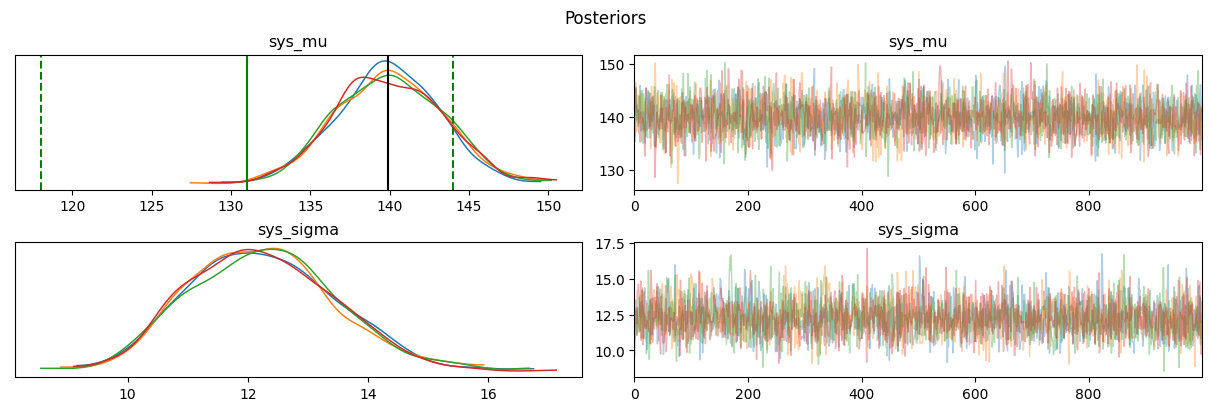

In [21]:
axes = az.plot_trace(idata_sys_model_norm_prior, compact=False);
axes[:, 0][0].axvline(118, color='green', linestyle='dashed')
axes[:, 0][0].axvline(144, color='green', linestyle='dashed')
axes[:, 0][0].axvline(131, color='green', linestyle='solid')
axes[:, 0][0].axvline(sys_df['value'].mean(), color='black')
plt.suptitle('Posteriors')
plt.show();
# Dashed green lines are normal range - solid green line is midpoint

In [22]:
sys_post_mu = idata_sys_model_norm_prior.posterior.sys_mu.to_dataframe().reset_index().drop(columns=['chain', 'draw'])
prob_high = ((sys_post_mu > 144).sum() / len(sys_post_mu)).values[0]
print(f'uniform model - probability mean systolic bp above normal: {prob_high}')

uniform model - probability mean systolic bp above normal: 0.11025


### Combo1 Priors

+ Combo priors
    + $bp \sim normal(\mu, \sigma)$
        + $\mu \sim Uniform(80, 190)$
        + $\sigma \sim Normal(7.5, 2)$

In [23]:
with pm.Model() as sys_model_combo1_prior:
    sys_mu = pm.Uniform('sys_mu', 80, 190)
    sys_sigma = pm.Normal('sys_sigma', 7.5, 2)

    sys_bp = pm.Normal("sys_bp", mu=sys_mu, sigma=sys_sigma, observed = sys_df['value'].values)
    
    prior = pm.sample_prior_predictive()
    trace3 = pm.sample()
    # post = pm.sample_posterior_predictive(trace3)
    idata_sys_model_combo1_prior = az.from_pymc3(trace=trace3, prior=prior)

/tmp/ipykernel_302646/1919430091.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sys_sigma, sys_mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


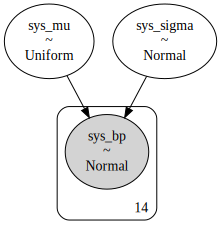

In [24]:
pm.model_to_graphviz(sys_model_combo1_prior)

In [25]:
idata_sys_model_combo1_prior

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

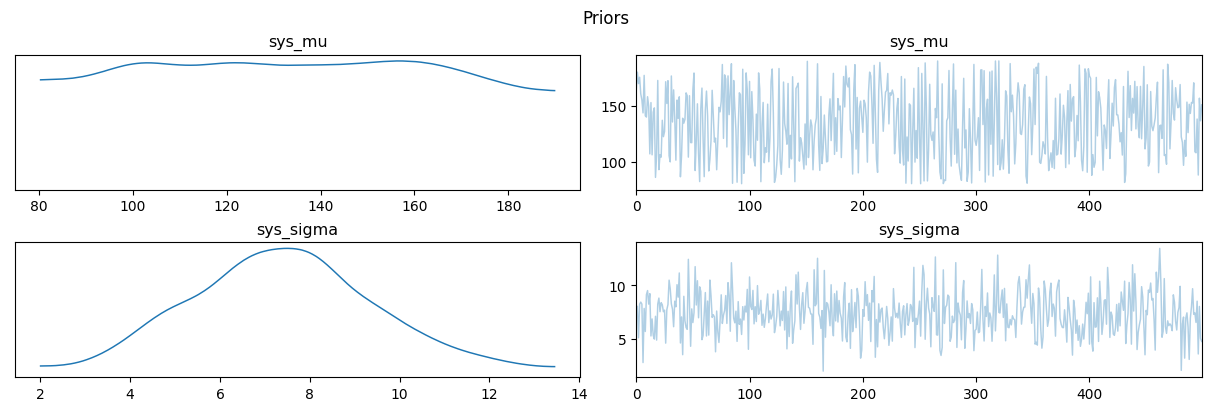

In [26]:
az.plot_trace(idata_sys_model_combo1_prior.prior, var_names=['sys_mu', 'sys_sigma']);
plt.suptitle('Priors')
plt.show();

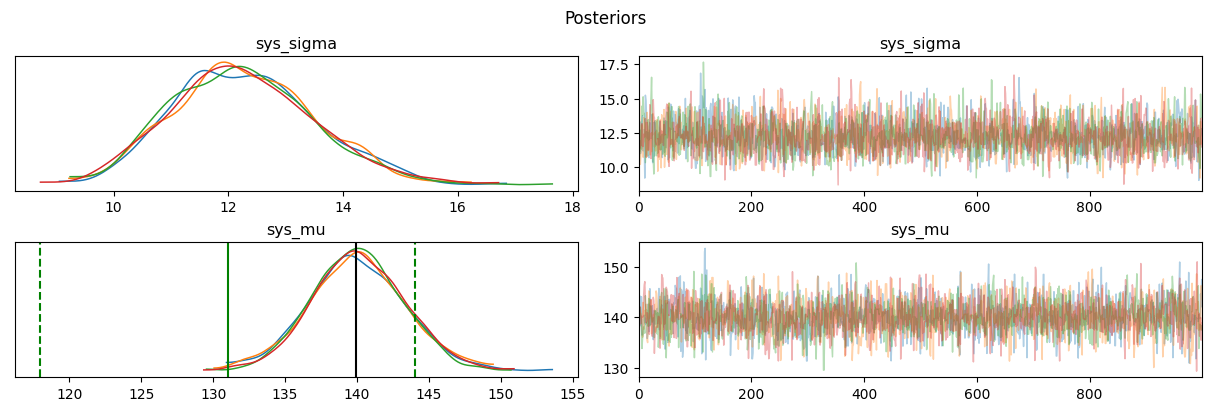

In [27]:
axes = az.plot_trace(idata_sys_model_combo1_prior, compact=False);
axes[:, 0][1].axvline(118, color='green', linestyle='dashed')
axes[:, 0][1].axvline(144, color='green', linestyle='dashed')
axes[:, 0][1].axvline(131, color='green', linestyle='solid')
axes[:, 0][1].axvline(sys_df['value'].mean(), color='black')
plt.suptitle('Posteriors')
plt.show();
# Dashed green lines are normal range - solid green line is midpoint

In [28]:
sys_post_mu = idata_sys_model_combo1_prior.posterior.sys_mu.to_dataframe().reset_index().drop(columns=['chain', 'draw'])
prob_high = ((sys_post_mu > 144).sum() / len(sys_post_mu)).values[0]
print(f'uniform model - probability mean systolic bp above normal: {prob_high}')

uniform model - probability mean systolic bp above normal: 0.11625


### Combo2 Priors

+ Combo2 priors
    + $bp \sim normal(\mu, \sigma)$
        + $\mu \sim Normal(131, max((190-131/3), (131-90/3))$
        + $\sigma \sim Uniform(1, 14)$

In [29]:
with pm.Model() as sys_model_combo2_prior:
    sys_mu = pm.Normal('sys_mu', 131, max(190-(131/3), 131-(90/3)))
    sys_sigma = pm.Uniform('sys_sigma', 1, 14)

    sys_bp = pm.Normal("sys_bp", mu=sys_mu, sigma=sys_sigma, observed = sys_df['value'].values)
    
    prior = pm.sample_prior_predictive()
    trace4 = pm.sample()
    # post = pm.sample_posterior_predictive(trace4)
    idata_sys_model_combo2_prior = az.from_pymc3(trace=trace4, prior=prior)

/tmp/ipykernel_302646/3933922485.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sys_sigma, sys_mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


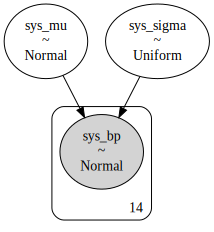

In [30]:
pm.model_to_graphviz(sys_model_combo2_prior)

In [31]:
idata_sys_model_combo2_prior

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

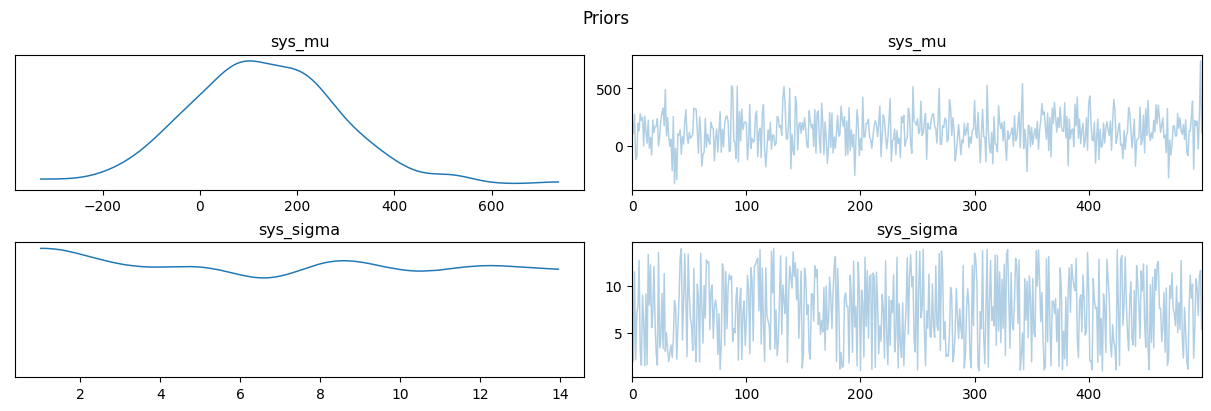

In [32]:
az.plot_trace(idata_sys_model_combo2_prior.prior, var_names=['sys_mu', 'sys_sigma']);
plt.suptitle('Priors')
plt.show();

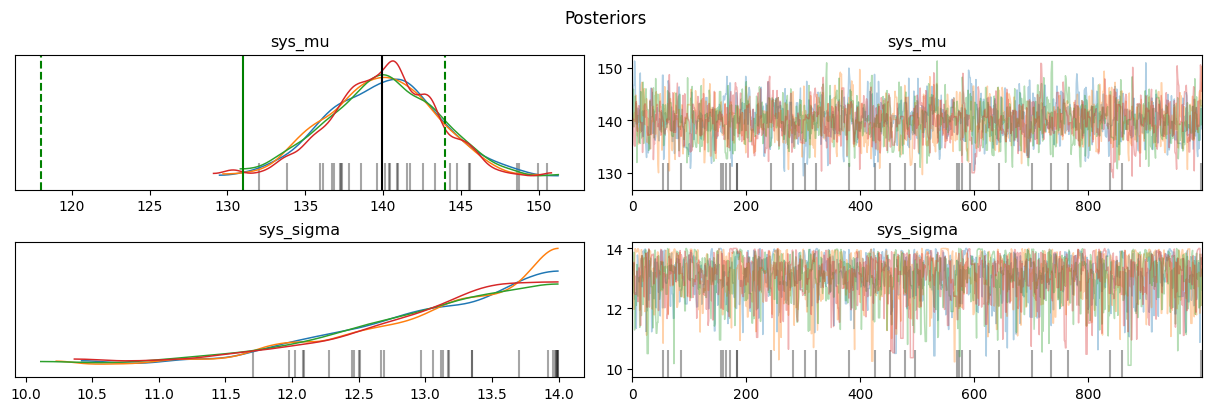

In [33]:
axes = az.plot_trace(idata_sys_model_combo2_prior, compact=False);
axes[:, 0][0].axvline(118, color='green', linestyle='dashed')
axes[:, 0][0].axvline(144, color='green', linestyle='dashed')
axes[:, 0][0].axvline(131, color='green', linestyle='solid')
axes[:, 0][0].axvline(sys_df['value'].mean(), color='black')
plt.suptitle('Posteriors')
plt.show();
# Dashed green lines are normal range - solid green line is midpoint

In [34]:
sys_post_mu = idata_sys_model_combo2_prior.posterior.sys_mu.to_dataframe().reset_index().drop(columns=['chain', 'draw'])
prob_high = ((sys_post_mu > 144).sum() / len(sys_post_mu)).values[0]
print(f'uniform model - probability mean systolic bp above normal: {prob_high}')

uniform model - probability mean systolic bp above normal: 0.12725


## Model Comparison

In [35]:
compare_dict = {'uni_priors': idata_sys_model_uni_prior, 'norm_priors': idata_sys_model_norm_prior,
                'combo1_prior': idata_sys_model_combo1_prior, 'combo2_prior': idata_sys_model_combo2_prior}
compare_df = az.compare(compare_dict)
compare_df

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
uni_priors,0,-61.927563,1.814518,0.000000,1.000000e+00,3.012758,0.000000,False,log
combo2_prior,1,-62.035142,1.930359,0.107579,1.484923e-15,3.022880,0.031136,False,log
combo1_prior,2,-63.229515,2.513833,1.301952,0.000000e+00,3.591556,0.580691,False,log
norm_priors,3,-63.286641,2.559814,1.359078,0.000000e+00,3.607924,0.596339,False,log


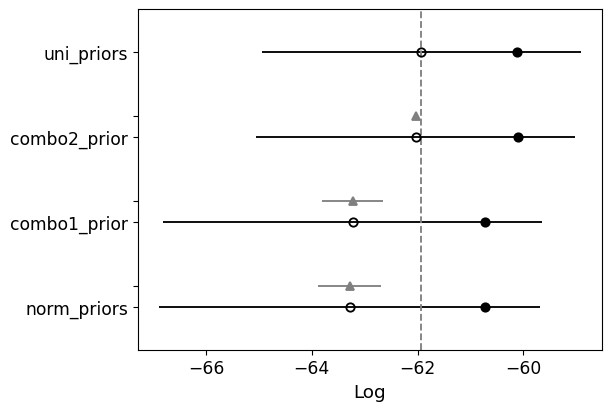

In [36]:
az.plot_compare(compare_df);

From the book Fig 2.16
```
Model comparison using LOO. The open dots represent the values of loo, the black dots are the predictive accuracy without the p_loo penalization term. The black segments represent the standard error for the LOO computations se. The grey segments, centered at the triangles, represent the standard errors of the difference dse between the values of LOO for each model and the best ranked model.
```
+ The uni_priors model and the combo2_priors models are just about even
+ Just for an exercise, I will combine these with most weight on the uni_priors model and less weight on the combo2_prior

# Model Weighted Averaging

In [37]:
weights = [0.75, 0.25]

with pm.Model() as model_weighted:
    weighted = pm.sample_posterior_predictive_w([trace1, trace4],
                                                 models=[sys_model_uni_prior, sys_model_combo2_prior],
                                                 weights=weights)
weighted

{'sys_bp': array([[146.80418558, 120.53119892, 123.46120744, ..., 134.13429597,
         126.45215414, 131.21425032],
        [137.29808237, 139.85709755, 142.09304046, ..., 163.4072863 ,
         147.41038538, 155.7869626 ],
        [129.33155477, 163.65193239, 146.93328727, ..., 150.43140136,
         141.61239973, 163.3615869 ],
        ...,
        [140.65593714, 131.32323292, 157.16568728, ..., 128.06808826,
         159.42123076, 146.49440871],
        [117.54942199, 149.52870903, 158.90990778, ..., 119.5928464 ,
         142.92389844, 146.78962897],
        [134.80142599, 140.98356581, 106.22092463, ..., 132.57315403,
         139.76497407, 132.63909982]])}

In [38]:
weighted_df = pd.DataFrame(weighted['sys_bp'])
weighted_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,146.804186,120.531199,123.461207,163.469083,168.888229,138.131229,155.466271,138.995182,123.766097,140.598548,157.577481,134.134296,126.452154,131.214250
1,137.298082,139.857098,142.093040,120.208093,119.410977,104.047702,167.277290,143.666018,132.385888,138.883961,156.695572,163.407286,147.410385,155.786963
2,129.331555,163.651932,146.933287,139.632188,143.833218,123.790213,168.179652,142.508859,135.119920,129.003557,108.994509,150.431401,141.612400,163.361587
3,150.087167,129.764651,159.808901,132.315433,155.185860,163.342878,133.275884,139.561442,157.087723,146.019206,133.585463,156.853594,149.626836,136.172851
4,141.246298,163.616345,141.106681,145.437624,149.619673,151.672013,147.912937,135.650998,129.186677,162.123575,145.636186,134.507285,140.743497,142.003181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,137.697307,127.096399,146.739037,141.403699,145.508348,138.372204,145.202688,132.715237,158.311422,141.786222,173.694535,135.844178,163.563978,145.374859
3996,138.890231,158.431015,136.890619,146.103490,145.790785,134.569568,133.113007,141.812348,131.436196,132.793451,114.772787,137.503856,100.221613,133.191680
3997,140.655937,131.323233,157.165687,140.778864,145.360713,126.501030,152.140681,142.024566,148.149278,166.353083,128.747909,128.068088,159.421231,146.494409
3998,117.549422,149.528709,158.909908,123.090585,140.737043,150.346226,142.061637,145.506711,152.436691,162.993190,152.564329,119.592846,142.923898,146.789629
